In [1]:
import berrylib.util as util
util.setup_nb()

In [2]:
from berrylib.constants import Y_I2, N_I2
import pickle
import berrylib.fast_inla as fast_inla
import berrylib.mcmc as mcmc
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

y=Y_I2
n=N_I2

fi = fast_inla.FastINLA(sigma2_n=15)

/Users/tbent/.mambaforge/envs/imprint2/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/imprint2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load = True
if load:
    with open('conditional_mcmc.pkl', 'rb') as f:
        mcmc_results, mcmc_arm_marg = pickle.load(f)
else:
    mcmc_results = []
    for sig_idx in range(fi.sigma2_n):
        mcmc_results.append(mcmc.mcmc_berry(
            np.stack((y[-1:], n[-1:]), axis=-1),
            fi.logit_p1,
            fi.thresh_theta,
            dtype=np.float64,
            n_samples=200000,
            sigma2_val=fi.sigma2_rule.pts[sig_idx]
        ))
    mcmc_arm_marg = mcmc.mcmc_berry(
        np.stack((y[-1:], n[-1:]), axis=-1),
        fi.logit_p1,
        fi.thresh_theta,
        dtype=np.float64,
        n_samples=200000,
    )
    with open('conditional_mcmc.pkl', 'wb') as f:
        pickle.dump((mcmc_results, mcmc_arm_marg), f)

In [4]:
import inlaw
from inlaw.berry_model import berry_model

sig2_rule = fi.sigma2_rule
fl = inlaw.FullLaplace(berry_model(4), "sig2", np.zeros((4,2)))

In [8]:
data = np.stack((y[-1:], n[-1:]), axis=-1)
logpost, x_max, hess, iters = fl(dict(sig2=fi.sigma2_rule.pts), data)
post = inlaw.inla.exp_and_normalize(logpost, sig2_rule.wts, axis=1)

In [9]:
# x_sigma2 = -np.diagonal(np.linalg.inv(hess), axis1=2, axis2=3)
# mu_arm = np.sum(post[...,None] * x_max * fi.sigma2_rule.wts[None, :, None], axis=1)
# var_arm = np.sum(post[..., None] * ((x_max - mu_arm[:, None, :]) ** 2 + x_sigma2) * fi.sigma2_rule.wts[None, :, None], axis=1)
# mu_arm, var_arm

In [10]:
%%time
arm_idx = 0
p_pinned = dict(sig2=fi.sigma2_rule.pts, theta=None)
cond_inla_f = inlaw.inla.build_conditional_inla(fl.log_joint_single, fl.spec)

CPU times: user 179 µs, sys: 1e+03 ns, total: 180 µs
Wall time: 183 µs


## adaptive quadrature rule.

this will get far enough out from the mode, but is more complicated and possibly slower. not sure!

In [11]:
mu_arm = x_max
sd_arm = np.sqrt(-np.diagonal(np.linalg.inv(hess), axis1=2, axis2=3))

In [12]:

def eval_cx(cx):
    return cond_inla_f(x_max, p_pinned, data, hess, cx, arm_idx)

cx_all = [mu_arm[None,...,arm_idx]]
arm_marg_all = [eval_cx(mu_arm[None,...,arm_idx])]
for i in range(8):
    a = i
    b = i + 1

    domain = np.linspace(a, b, 5)[1:]
    cx = mu_arm[None, ..., arm_idx] + sd_arm[None, ..., arm_idx] * domain[:, None, None]
    lp = eval_cx(cx)
    
    cx_all.append(cx)
    arm_marg_all.append(lp)


In [13]:
cx_all = np.concatenate(cx_all, axis=0)
arm_marg_all = np.concatenate(arm_marg_all, axis=0)

In [14]:
order = np.argsort(cx_all[:,0,0])
cx_all = cx_all[order]
arm_marg_all = arm_marg_all[order]
a = cx_all[0]
b = cx_all[-1]
wts = np.tile(((b - a) / cx_all.shape[0])[None], (cx_all.shape[0], 1, 1))
arm_marg = inlaw.inla.exp_and_normalize(arm_marg_all, wts, axis=0)

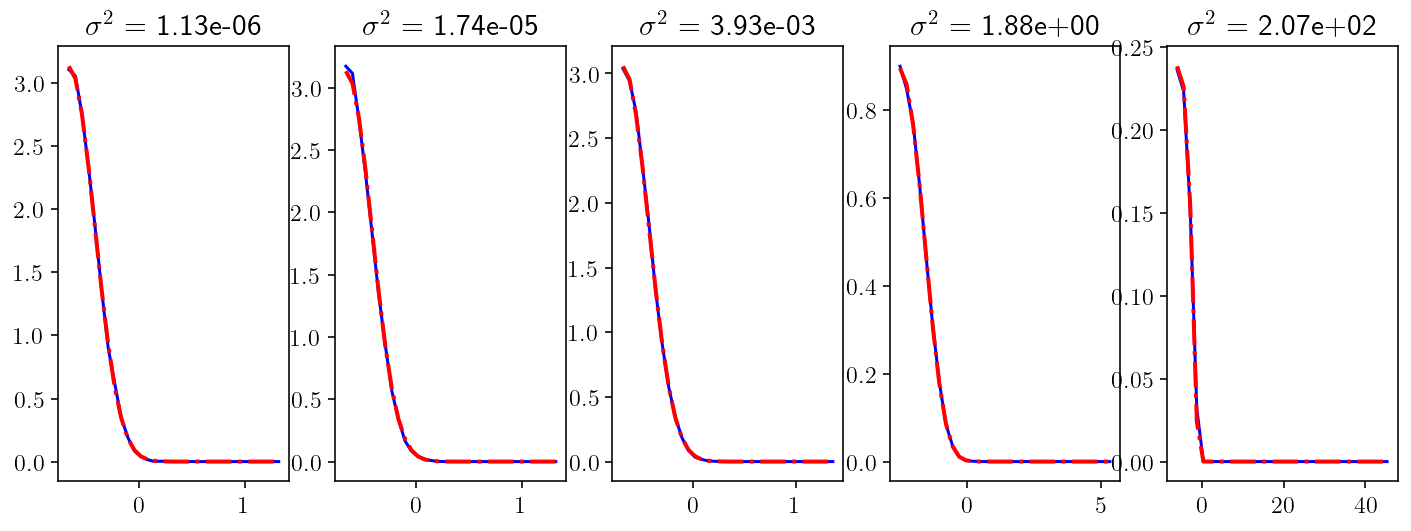

In [15]:


plt.figure(figsize=(12, 4))
for j, sig_idx in enumerate(range(fi.sigma2_n)[::3]):
    mcmc_arm = mcmc_results[sig_idx]["x"][0]["theta"][0, :, arm_idx]
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, cx_all[:,0,sig_idx], wts[:, 0, sig_idx])

    plt.subplot(1,5,1 + j)
    plt.title(f'$\sigma^2$ = {fi.sigma2_rule.pts[sig_idx]:5.2e}')
    plt.plot(cx_all[:,0,sig_idx], mcmc_p_ti_g_y, 'b-')
    # plt.plot(t_i.pts, arm_marg[:, 0, sig_idx], 'r-.', linewidth=2.0)
    plt.plot(cx_all[:, 0, sig_idx], arm_marg[:, 0, sig_idx], 'r-.', linewidth=2.0)
plt.show()

## gauss-hermite around the mode

pre-specified so it's all vectorizable, but it's also pretty accurate

In [17]:
hg_pts, hg_wts = np.polynomial.hermite.hermgauss(20)
n_sds = 2
mu_arm = x_max
sd_arm = np.sqrt(-np.diagonal(np.linalg.inv(hess), axis1=2, axis2=3))
cx = mu_arm[None, ..., arm_idx] + n_sds * sd_arm[None, ..., arm_idx] * hg_pts[:, None, None]
lp = cond_inla_f(x_max, p_pinned, data, hess, cx, arm_idx)
wts = sd_arm[None, ..., arm_idx] * hg_wts[:, None, None]#(hg_wts / np.exp(-hg_pts ** 2))[:, None, None]

arm_marg = inlaw.inla.exp_and_normalize(lp, wts, axis=0)

In [18]:
np.sum(hg_wts * 4)

7.0898154036220635

In [19]:
np.sum(hg_wts * 1.0 / np.sqrt(np.pi))

1.0

In [20]:
sd = 2
for n in range(50, 500, 50):
    gr = util.gauss_rule(n, -10 * sd, 10 * sd)
    gp, gw = gr.pts, gr.wts
    np.sum(gw * np.exp(-gp ** 2 / (2 * sd ** 2)) / np.sqrt(2 * np.pi * sd ** 2))
    A = np.sum(gw * np.exp(-gp ** 2) / np.sqrt(2 * np.pi * sd ** 2))
    print(f"{n} {A}")

50 0.35231910308306214
100 0.3535533905810784
150 0.35355339059327473
200 0.3535533905932769
250 0.3535533905932739
300 0.35355339059327484
350 0.3535533905932802
400 0.3535533905932806
450 0.3535533905932805


In [21]:
1.0 / np.sqrt(2)

0.7071067811865475

In [22]:
def f(x):
    return np.sin(np.exp(-x ** 2))
def gauss_I(n, scale=1.0):
    gr = util.gauss_rule(n, -10 * scale, 10 * scale)
    gp, gw = gr.pts, gr.wts
    y = f(gp)
    return np.sum(y * gw)

In [28]:
import inlaw.quad

In [33]:
def herm_I(n, scale=1.0):
    hr = inlaw.quad.gauss_herm_rule(n, center=0, scale=scale)
    return np.sum(hr.wts * f(hr.pts))

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_21817/1063043724.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(ns, np.log10(gerr), 'b-')
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_21817/1063043724.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.plot(ns, np.log10(herr[i]), label=f'Hermite {scales[i]:.2f}')


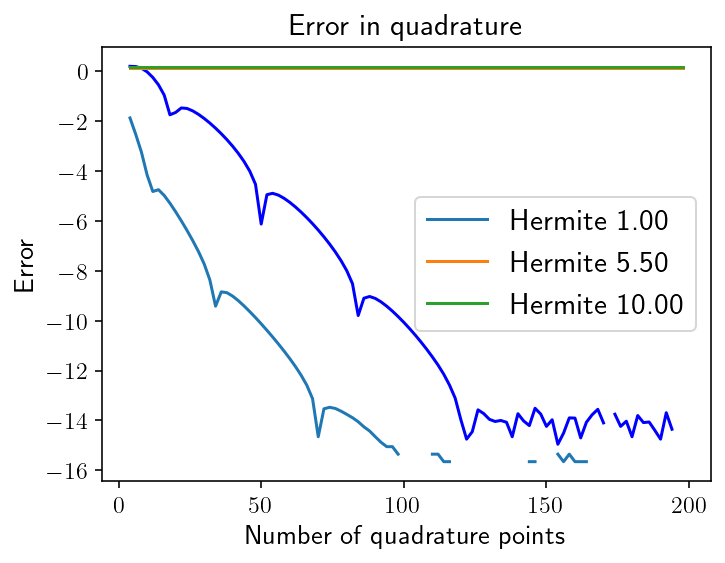

In [46]:
exact = herm_I(100, scale=1.0)
gerr = []
scales = np.linspace(1.0, 10.0, 3)
herr = [[] for i in range(len(scales))]
ns = range(4, 200, 2)
for n in ns:
    gerr.append(np.abs(gauss_I(n, scale=1.0) - exact))
    for i, scale in enumerate(scales):
        herr[i].append(np.abs(herm_I(n, scale=scale) - exact))
# Plot comparing gauss quadrature and hermite quadrature
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ns, np.log10(gerr), 'b-')
for i in range(len(herr)):
    plt.plot(ns, np.log10(herr[i]), label=f'Hermite {scales[i]:.2f}')
plt.legend()
plt.xlabel('Number of quadrature points')
plt.ylabel('Error')
plt.title('Error in quadrature')
plt.show()


In [31]:
hg2_wts = hg_wts / np.exp(-hg_pts ** 2)

In [70]:
np.sum(f(hg_pts) * hg2_wts)

1.6083712817413818

In [55]:
64 ** 4 * 10000 / 1e9

167.77216

In [53]:
B = 1.0 / (np.sqrt(2 * 10 ** 2))
A / B

0.9999999968918012

In [48]:
A, B

(3.1295100234213735e-05, 0.03989422804014327)

In [16]:
wts.sum(axis=0)

array([[ 0.43809031,  0.43809285,  0.43810227,  0.43814303,  0.43836304,  0.4398092 ,  0.45057608,
         0.52653162,  0.8638713 ,  1.72763999,  3.51457215,  6.71546791, 11.37982805, 16.63751296,
        20.70649248]])

In [17]:
sd_arm[0, :, 0] * 2

array([ 0.49433198,  0.49433484,  0.49434548,  0.49439146,  0.49463972,  0.49627153,  0.50842066,
        0.59412731,  0.97477438,  1.94943297,  3.96577   ,  7.57759408, 12.8407609 , 18.77342302,
       23.36477474])

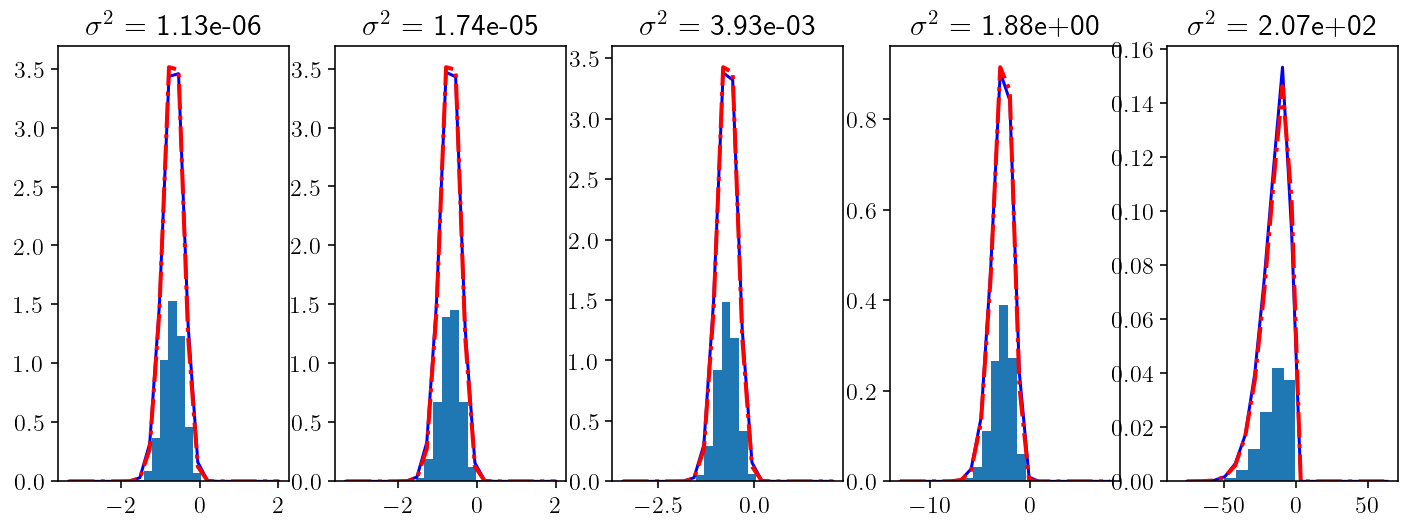

In [19]:
plt.figure(figsize=(12, 4))
for j, sig_idx in enumerate(range(fi.sigma2_n)[::3]):
    mcmc_arm = mcmc_results[sig_idx]["x"][0]["theta"][0, :, arm_idx]
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, cx[:, 0, sig_idx], wts[:, 0, sig_idx])

    plt.subplot(1,5,1 + j)
    plt.title(f'$\sigma^2$ = {fi.sigma2_rule.pts[sig_idx]:5.2e}')
    plt.plot(cx[:, 0, sig_idx], mcmc_p_ti_g_y, 'b-')
    plt.plot(cx[:, 0, sig_idx], arm_marg[:, 0, sig_idx], 'r-.', linewidth=2.0)
    plt.hist(mcmc_arm, density=True)
plt.show()

## pre-specified fixed quad rule.

this is slow and silly, but works.

In [94]:
arm_idx = 0
t_i = util.simpson_rule(101, -15, 2)
p_pinned = dict(sig2=fi.sigma2_rule.pts, theta=None)
cond_inla_f = inlaw.inla.build_conditional_inla(fl.log_joint_single, fl.spec)
cx = np.tile(t_i.pts[:, None, None], (1, x_max.shape[0], x_max.shape[1]))
lp = cond_inla_f(x_max, p_pinned, data, hess, cx, arm_idx)
arm_marg = inlaw.inla.exp_density(lp, t_i.wts[:, None, None], axis=0)
# arm_marg /= np.sum(arm_marg * t_i.wts[:, None, None], axis=0)[None]

(101, 1, 15) (101, 1, 1)


In [95]:
cond_inla_f = inlaw.inla.build_conditional_inla(fl.log_joint_single, fl.spec)
lp = cond_inla_f(x_max, p_pinned, data, hess, x_max[None, :, :, arm_idx], arm_idx)

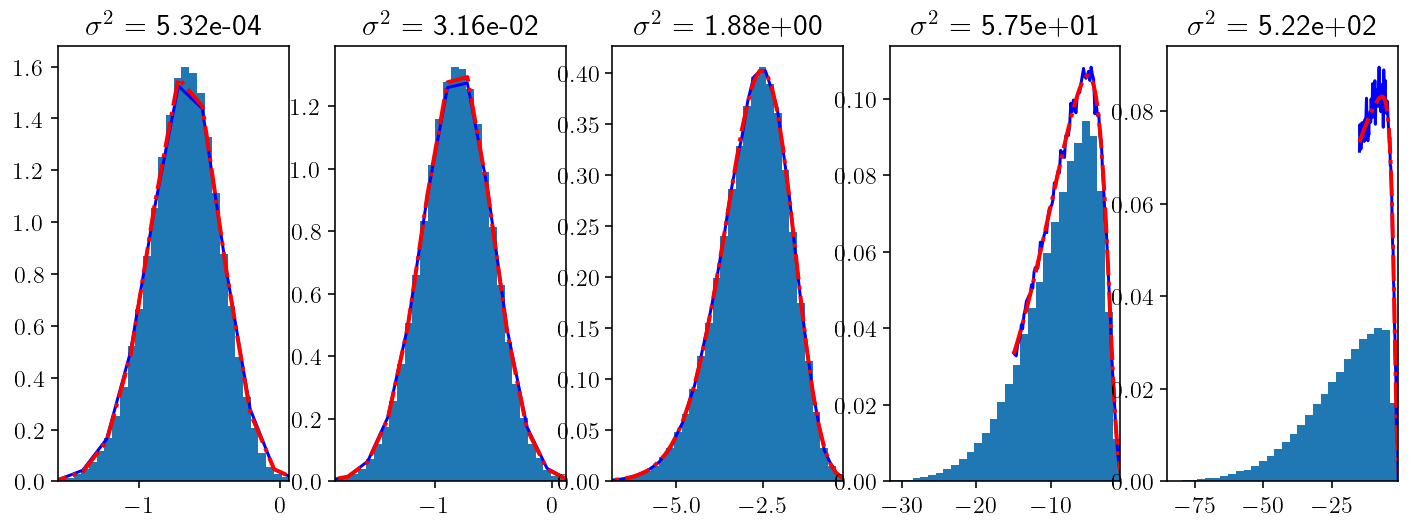

In [96]:


plt.figure(figsize=(12, 4))
for j, sig_idx in enumerate(range(fi.sigma2_n)[5::2]):
    mcmc_arm = mcmc_results[sig_idx]["x"][0]["theta"][0, :, arm_idx]
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, t_i.pts, t_i.wts)

    plt.subplot(1,5,1 + j)
    plt.title(f'$\sigma^2$ = {fi.sigma2_rule.pts[sig_idx]:5.2e}')
    plt.plot(t_i.pts, mcmc_p_ti_g_y, 'b-')
    plt.plot(t_i.pts, arm_marg[:, 0, sig_idx], 'r-.', linewidth=2.0)
    window = np.quantile(mcmc_arm, [0.0005, 0.9995])
    plt.hist(mcmc_arm, bins=np.linspace(*window, 31), density=True)
    plt.xlim(*window)
plt.show()

In [214]:
arm_marg = np.sum(cond_arm * fi.sigma2_rule.5ts[None, None], axis=2)[:, 0] / np.sum(fi.sigma2_rule.wts)

In [148]:
t_i.pts[:11], t_i.wts[:11]

(array([-15.  , -14.83, -14.66, -14.49, -14.32, -14.15, -13.98, -13.81, -13.64, -13.47, -13.3 ]),
 array([0.05666667, 0.22666667, 0.11333333, 0.22666667, 0.11333333, 0.22666667, 0.11333333,
        0.22666667, 0.11333333, 0.22666667, 0.11333333]))

## Jensen-Shannon divergence

[Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence)

https://stats.stackexchange.com/questions/6907/an-adaptation-of-the-kullback-leibler-distance/6937#6937


The symmetric KL divergence doesn't behave well when there are zeros in either distribution. The JS divergence solves this issue by comparing to the midpoint distribution.

More generally, the issue we are faced with is computing a norm of distributions. so something like the L2 norm of the difference of the functions would be fine. But the more probabalistic/informational divergence metrics are probably better.

One way we can avoid this entirely is to move to evaluating error in terms of the final output, the exceedance. In many cases, all we are going to care about is the exceedance prob for some threshold. This is a scalar (or vector with multiple arms) and would make error tolerances more concrete and understandable. 

In [87]:
import scipy.special
def js_div(x, y, wts):
    R = 0.5 * (x + y)
    a = np.sum(wts * scipy.special.rel_entr(x, R))
    b = np.sum(wts * scipy.special.rel_entr(y, R))
    return 0.5 * (a + b)

In [106]:
import pandas as pd
df = pd.DataFrame(dict(sig2 = fi.sigma2_rule.pts))
df['JS_G_M'] = 0
df['JS_L_M'] = 0
for i, sig_idx in enumerate(range(fi.sigma2_n)):
    mcmc_arm = mcmc_results[sig_idx]["x"][0]["theta"][0, :, arm_idx]
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, t_i.pts, t_i.wts)
    gaussian = scipy.stats.norm.pdf(t_i.pts, theta_max[-1, sig_idx, 0], theta_sigma[-1, sig_idx, 0])
    df.at[i, 'JS_G_M'] = js_div(mcmc_p_ti_g_y, gaussian, t_i.wts)
    df.at[i, 'JS_L_M'] = js_div(mcmc_p_ti_g_y, laplace[sig_idx], t_i.wts)
df

,sig2,JS_G_M,JS_L_M
0,0.000001,0.001329,0.001022
1,0.000002,0.000861,0.001355
2,0.000005,0.001104,0.001107
3,0.000017,0.001770,0.000754
4,0.000085,0.001628,0.000636
5,0.000532,0.001511,0.000792
6,0.003932,0.001354,0.000626
7,0.031623,0.001123,0.000299
8,0.254316,0.002730,0.000050
9,1.877937,0.015512,0.000024


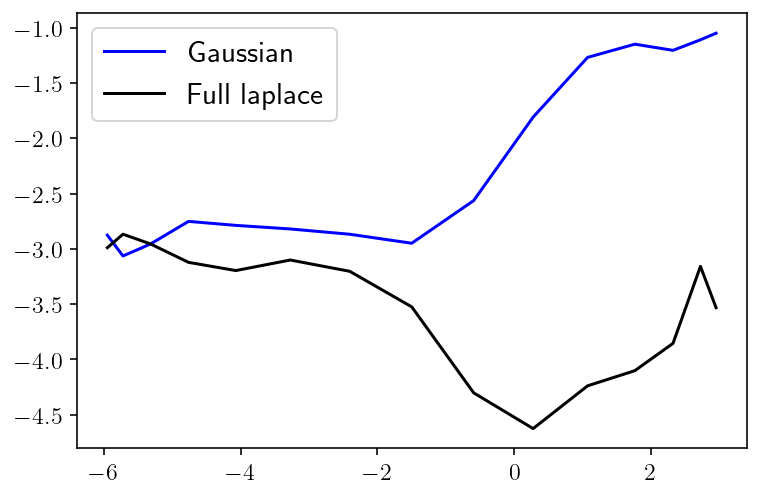

In [111]:
plt.plot(np.log10(df['sig2']), np.log10(df['JS_G_M']), 'b-', label='Gaussian')
plt.plot(np.log10(df['sig2']), np.log10(df['JS_L_M']), 'k-', label='Full laplace')
plt.legend()
plt.show()

In [75]:
mcmc_arm = mcmc_arm_marg["x"][0]["theta"][0, :, arm_idx]
mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, t_i.pts, t_i.wts)

In [76]:
from scipy.special import logit

In [77]:
t_i = util.simpson_rule(101, -15, 2)
_, _, _, laplace_integral, hess_inv = cond_laplace(t_i, 20)


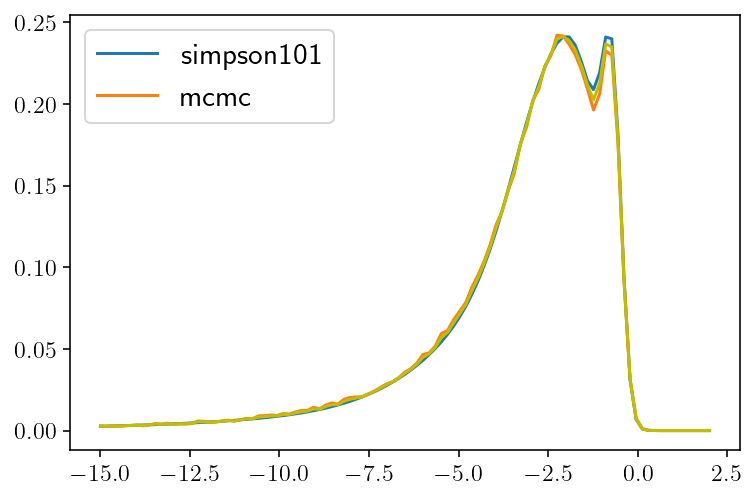

In [79]:

R = 0.5 * (mcmc_p_ti_g_y + laplace_integral)
plt.plot(t_i.pts, laplace_integral, label=f'simpson101')
plt.plot(t_i.pts, mcmc_p_ti_g_y, label='mcmc')
plt.plot(t_i.pts, R, 'y-')

# t_i = util.gauss_rule(20, -15, 2)
# _, _, _, laplace_integral = cond_laplace(t_i, 20)
# plt.plot(t_i.pts, laplace_integral, label=f'gauss20')

# plt.vlines([logit(0.1) - logit(0.3), logit(0.2) - logit(0.3)], 0, 0.25, 'k')

plt.legend()
plt.show()

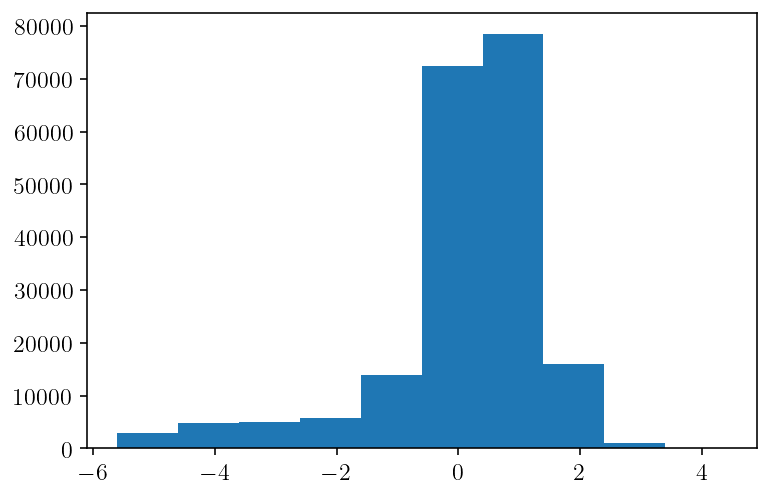

In [42]:
plt.hist(np.log10(mcmc_arm_marg['x'][0]['sigma2'][0]))
plt.show()

## Delete rows and cols from the hessian

In [139]:
np.random.seed(1)
a = np.random.rand(4)
b = np.random.rand()
M = np.full((4,4), b) + np.diag(a)
Minv = np.linalg.inv(M)
subs = Minv[1:, 1:]

In [140]:
np.linalg.slogdet(subs)[1]

3.743197731903968

In [150]:
np.linalg.slogdet(np.linalg.inv(M[1:, 1:]))[1]

3.4419502172927148

In [149]:
cho = np.linalg.cholesky(Minv)
np.log(np.diag(cho ** 2).prod())

4.316292639218582

In [141]:
np.linalg.slogdet(Minv)[1]

4.316292639218582